In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('subsampling.tsv', sep='\t')

In [4]:
df.head()

,group,subset,valid,maxacc,diff,expid
0,tv,460,0.816105,0.867246,0.051141,463
1,tv,460,0.831579,0.846800,0.015221,188
2,tv,57,0.722105,0.711667,-0.010438,277
3,tv,921,0.828737,0.841379,0.012642,846
4,tv,1440,0.848000,0.865104,0.017104,612


In [5]:
df["proportion"] = round(df["subset"] / np.max(df["subset"]) * 100).astype(int)

In [6]:
df["proportion"].unique()

array([ 32,   4,  64, 100,   8,  16])

In [7]:
gb = df.groupby("subset")

In [8]:
max_acc = np.mean(df[df["proportion"] == 100]["valid"])
min_acc = np.mean(df[df["proportion"] == 4]["valid"])

In [9]:
min_acc

0.7371388181818183

In [10]:
def logistic(x, k, x0):
    return (max_acc / (1 + np.exp(-k * (x - x0))) )

def loglinear(x, a, b):
    return a * np.log2(x) + b 

[]

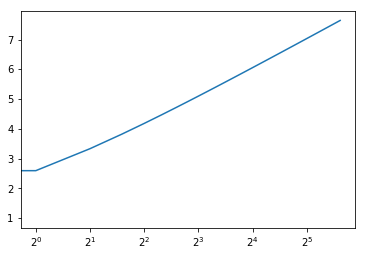

In [11]:
fig, ax = plt.subplots(1)
ax.plot(loglinear(np.linspace(1, 100), 1, 1))
ax.semilogx(basex=2)

In [12]:
import scipy.optimize as opt

In [13]:
params_logistic, cov_logistic = opt.curve_fit(logistic, df["proportion"], df["valid"], p0=[1, 1])
params_loglinear, cov_loglinear = opt.curve_fit(loglinear, df["proportion"], df["valid"], p0=[1, 1])


/Users/arokem/.virtualenvs/subsampling/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [14]:
df["model"] = logistic(df["proportion"], *params_loglinear)

In [15]:
df_model = pd.DataFrame()

In [16]:
df_means = df.groupby(['proportion']).mean()
df_stds = df.groupby(['proportion']).std()

In [17]:
df_means

,subset,valid,maxacc,diff,expid,model
proportion,,,,,,
4,57.0,0.737139,0.739029,0.001890,505.363636,0.447526
8,115.0,0.769340,0.820079,0.050740,505.363636,0.469243
16,230.0,0.812287,0.821283,0.008996,505.363636,0.511962
32,460.0,0.828191,0.833273,0.005082,505.363636,0.591816
64,921.0,0.841053,0.849905,0.008852,505.363636,0.715681
100,1440.0,0.859014,0.849922,-0.009092,505.363636,0.795195


In [18]:
df_means = df.groupby(['proportion']).mean()

In [19]:
p_target =  max_acc * 0.95

In [20]:
max_acc

0.8590144545454546

In [21]:
p_target

0.8160637318181818

In [22]:
def target(x0):
    return np.abs(loglinear(x0, *params_loglinear) - p_target)

In [23]:
target(10)

0.036643838674820906

In [24]:
x_target = opt.fmin(target, 10)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 22
         Function evaluations: 44


In [25]:
x_target

array([27.18035889])

In [26]:
import palettable

In [27]:
palette = np.array(palettable.wesanderson.Zissou_5.colors)/255

In [28]:
rmse_loglinear = np.sqrt(np.mean(loglinear(df['proportion'], *params_loglinear) - df['valid'] ** 2))
rmse_logistic = np.sqrt(np.mean(logistic(df['proportion'], *params_logistic) - df['valid'] ** 2))

In [29]:
rmse_logistic, rmse_loglinear

(0.39480100621948877, 0.39133994652549287)

/Users/arokem/.virtualenvs/subsampling/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


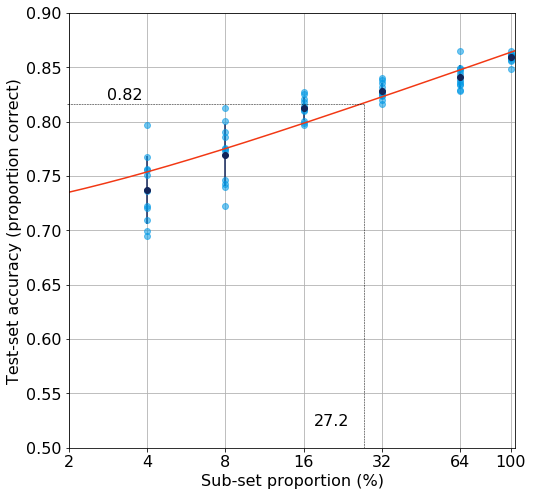

In [30]:
font = {'size': 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots()
ax.plot(df['proportion'], df['valid'], 'o', alpha=0.55, color=palette[0])
ax.plot(np.linspace(0, 110, 1000), loglinear(np.linspace(1, 110, 1000), *params_loglinear), color=palette[2])
#ax.plot(np.linspace(3.7, 100, 1000), logistic(np.linspace(3.7, 100, 1000), *params_logistic), color=palette[4])
ax.errorbar(df_means.index, df_means['valid'], yerr=df_stds['valid'], linestyle="None", marker="o", color=palette[1])
ax.semilogx(basex=2)
ax.set_xticks([2, 4, 8, 16, 32, 64, 100])
ax.set_xticklabels([2, 4, 8, 16, 32, 64, 100])
ax.minorticks_off()
ax.grid("on")
ax.set_ylim([0.5, 0.9])
ax.set_xlim([2, 104])
ax.plot([x_target, x_target], [0.5, p_target], 'k--', linewidth=0.5)
ax.plot([0, x_target], [p_target, p_target], 'k--', linewidth=0.5)
#ax.set_xticks([20.84], minor = True)
ax.set_yticks([p_target], minor=True)
ax.text(17.5, 0.52, "27.2")
ax.text(2.8, 0.82, "0.82")
#ax.set_xticklabels([20.84], minor=True)
#ax.set_yticklabels(["%2.2f"%p_target], minor=True)
ax.set_ylabel("Test-set accuracy (proportion correct)")
ax.set_xlabel("Sub-set proportion (%)")
fig.set_size_inches([8, 8])

fig.savefig('./test.png')

In [31]:
cifar_subsample = np.array([[0.1004, 0.2204, 0.1344, 0.2954, 0.3978, 0.505, 0.6452, 0.7278],
                            [0.128, 0.1616, 0.1936, 0.2574, 0.3714, 0.3738, 0.5708, 0.7348],
                            [0.104, 0.2186, 0.2102, 0.3484, 0.3416, 0.3038, 0.527, 0.66],
                            [0.0974, 0.1874, 0.1646, 0.1866, 0.3068, 0.3154, 0.5074, 0.5946],
                            [0.1468, 0.099, 0.1316, 0.1934, 0.2356, 0.2762, 0.345, 0.4644],
                            [0.1112, 0.1246, 0.1046, 0.1302, 0.1092, 0.1478, 0.191, 0.188],
                            [0.0942, 0.0798, 0.0942, 0.101, 0.0948, 0.1046, 0.1084, 0.104]])

In [32]:
data_proportion = [1, 2, 4, 8, 16, 32, 64, 100]

In [33]:
from itertools import cycle
palette_cyc = cycle(palette)

In [34]:
palette_cyc

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 60
[272.87139893]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 64
[512.72888184]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 70
[1306.18304443]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 72
[2113.13867188]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 90
[51296.83428955]
[1.53590778e+18]
[6.338253e+29]


/Users/arokem/.virtualenvs/subsampling/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


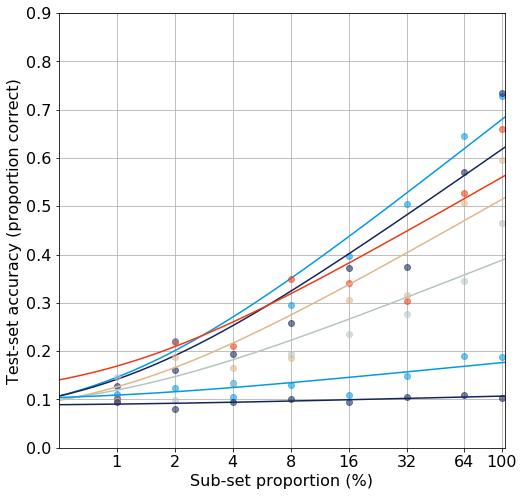

In [35]:
fig, ax = plt.subplots()
for ii, this in enumerate(cifar_subsample):
    color = next(palette_cyc)
    params_loglinear, cov_loglinear = opt.curve_fit(loglinear, data_proportion,  this, p0=[1, 1])
    def target(x0):
        return np.abs(loglinear(x0, *params_loglinear) - p_target)
    p_target =  max_acc * 0.95
    x_target = opt.fmin(target, 10)
    print(x_target)
    font = {'size': 16}
    matplotlib.rc('font', **font)

    ax.plot(data_proportion, this, 'o', alpha=0.55, color=color)
    ax.plot(np.linspace(0, 110, 1000), loglinear(np.linspace(1, 110, 1000), *params_loglinear), color=color)
    ax.semilogx(2)
    ax.set_xticks(data_proportion)
    ax.set_xticklabels(data_proportion)
    ax.minorticks_off()
    ax.grid("on")
    ax.set_ylim([0, 0.9])
    ax.set_xlim([0.5, 104])
    ax.set_ylabel("Test-set accuracy (proportion correct)")
    ax.set_xlabel("Sub-set proportion (%)")
    fig.set_size_inches([8, 8])

fig.savefig('./cifar.png')

In [36]:
learn1 = pd.read_csv('./learn.1.tsv', delimiter='\t')

In [37]:
learn1["proportion"] = round(learn1["subset"] / np.max(learn1["subset"]) * 100).astype(int)

In [38]:
learn1.head()

,group,subset,learningiter,acc,expid,proportion
0,tv,460,0,0.378406,463,32
1,tv,460,250,0.511884,463,32
2,tv,460,500,0.597536,463,32
3,tv,460,750,0.636667,463,32
4,tv,460,1000,0.721884,463,32


In [39]:
gb_prop = learn1.groupby("proportion")

In [40]:
learn1.proportion.unique()

array([ 32,   4,  64, 100,   8,  16])

/Users/arokem/.virtualenvs/subsampling/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/arokem/.virtualenvs/subsampling/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


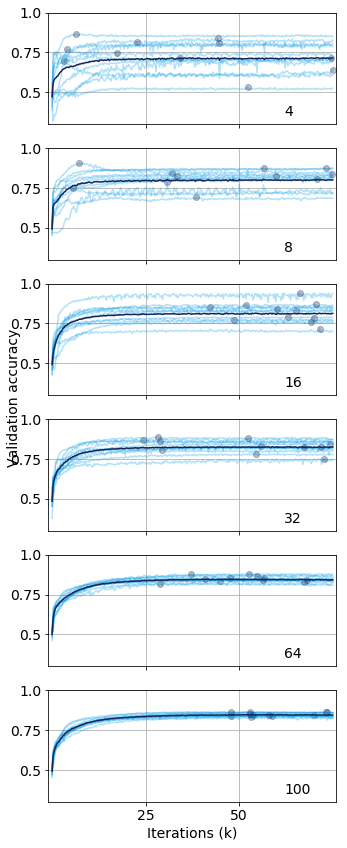

In [47]:
font = {'size': 14}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(6, 1)
ax = ax.ravel()

for ii, prop in enumerate([4, 8, 16, 32, 64, 100]):
    a = ax[ii]
    gb_id = learn1.iloc[gb_prop.groups[prop]].groupby("expid")
    for k, exp in gb_id:
        a.plot(exp['learningiter'], exp['acc'], color=palette[0], alpha=0.3)
        a.plot(exp['learningiter'][np.argmax(exp['acc'])], np.max(exp['acc']), 'o', color=palette[1], alpha=0.3)
    a.plot(exp['learningiter'], 
                 learn1.iloc[gb_prop.groups[prop]].groupby("learningiter").mean()['acc'],
                 color=palette[1])
    a.set_ylim([0.3, 1.0])
    a.set_xlim([-1000, 76000])
    a.text(62000, 0.35, prop)
    a.grid("on")
    a.set_yticklabels('')
    a.set_xticks([25000, 50000])
    a.set_xticklabels([])
    a.set_yticks([0.5, 0.75, 1])
    a.set_yticklabels(a.get_yticks())

ax[3].text(-12000, 1.5, 'Validation accuracy', rotation=90)
#ax[3].text(set_ylabel()

ax[-1].set_xlabel("Iterations (k)")
ax[-1].set_xticklabels(["25", "50"])
fig.set_size_inches([5, 12])
plt.tight_layout()
fig.savefig('./learning.png')


In [42]:
palette = np.concatenate([palette, [(np.array(palettable.wesanderson.Chevalier_4.colors)/255)[1]]])

In [43]:
palette

array([[0.        , 0.6       , 0.90196078],
       [0.07058824, 0.14509804, 0.35294118],
       [0.94901961, 0.21960784, 0.07843137],
       [0.8745098 , 0.71764706, 0.54509804],
       [0.71372549, 0.76470588, 0.77254902],
       [0.99607843, 0.79215686, 0.28627451]])

/Users/arokem/.virtualenvs/subsampling/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


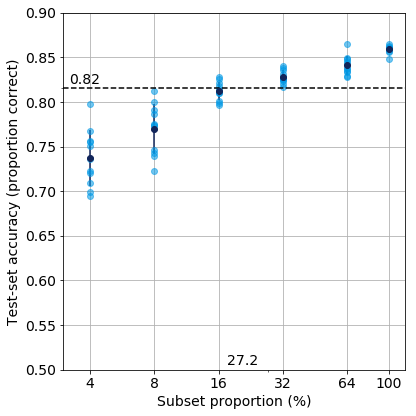

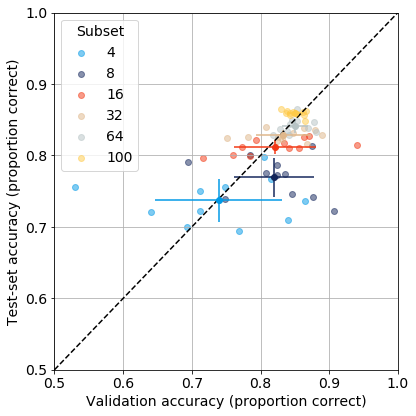

In [44]:
font = {'size': 14}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(1)
ax.plot(df['proportion'], df['valid'], 'o', alpha=0.55, color=palette[0])
ax.plot(np.linspace(0.1, 110, 1000), loglinear(np.linspace(0.1, 110, 1000), *params_loglinear), color=palette[2])
ax.errorbar(df_means.index, df_means['valid'], yerr=df_stds['valid'], linestyle="None", marker="o", color=palette[1])
ax.semilogx()
ax.set_xticks(df['proportion'].unique())
ax.set_xticklabels(df['proportion'].unique())
ax.minorticks_off()
ax.grid("on")
ax.set_ylim([0.5, 0.9])
ax.set_xlim([3, 120])
ax.plot([x_target, x_target], [0.5, p_target], 'k--')
ax.plot([3, x_target], [p_target, p_target], 'k--')
ax.set_xticks([27.2], minor = True)
ax.set_yticks([p_target], minor=True)
ax.text(17.5, 0.505, "27.2")
ax.text(3.2, 0.82, "0.82")
#ax.set_xticklabels([20.84], minor=True)
#ax.set_yticklabels(["%2.2f"%p_target], minor=True)
ax.set_ylabel("Test-set accuracy (proportion correct)")
ax.set_xlabel("Subset proportion (%)")
fig.set_size_inches([6, 6])
plt.tight_layout()
#fig.savefig('./test.png')
fig, ax = plt.subplots(1)

i = 0
gb_prop = df.groupby(["proportion"])
for k, g in gb_prop:
    ax.scatter(g['maxacc'], g['valid'], color=palette[i], label=k, alpha=0.5)
    ax.legend(title="Subset")
    ax.errorbar(np.mean(g['maxacc']), np.mean(g['valid']), 
                yerr=np.std(g['valid']), xerr=np.std(g['maxacc']), color=palette[i], alpha=1, marker='o')
    i += 1
ax.grid("on")
ax.plot([0.5, 1.0], [0.5, 1.0], 'k--')
ax.set_ylim([0.5, 1.0])
#ax.set_yticklabels()
ax.set_xlim([0.5, 1])
ax.set_ylabel("Test-set accuracy (proportion correct)")
ax.set_xlabel("Validation accuracy (proportion correct)")
fig.set_size_inches([6, 6])
plt.tight_layout()
fig.savefig('./diff.png')

In [45]:
learn2 = pd.read_csv('./learn.2.tsv', delimiter='\t')

/Users/arokem/.virtualenvs/subsampling/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/arokem/.virtualenvs/subsampling/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


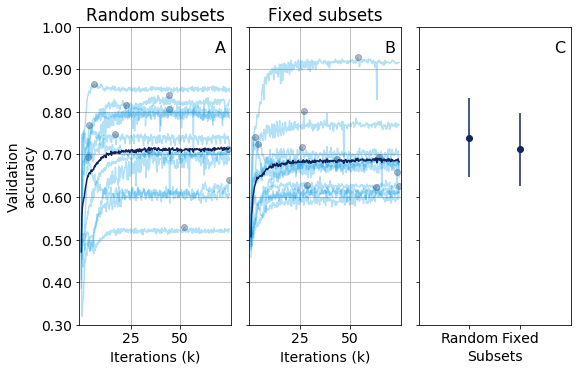

In [46]:
font = {'size': 14}
matplotlib.rc('font', **font)

gb_prop = learn1.groupby("proportion")
fig, ax = plt.subplots(1, 3)
ax = ax.ravel()

kkk = [learn1.iloc[gb_prop.groups[4]], learn2]
for ii, gb_id in enumerate([learn1.iloc[gb_prop.groups[4]].groupby("expid"), 
                            learn2.groupby("expid")]):
    a = ax[ii]
    for k, exp in gb_id:
        a.plot(exp['learningiter'], exp['acc'], color=palette[0], alpha=0.3)
        a.plot(exp['learningiter'][np.argmax(exp['acc'])], np.max(exp['acc']), 'o', color=palette[1], alpha=0.3)
    a.plot(exp['learningiter'], 
           kkk[ii].groupby("learningiter").mean()['acc'],
           color=palette[1])
    a.set_ylim([0.3, 1.0])
    a.set_xlim([-1000, 76000])
    a.grid("on")
    a.set_yticklabels('')
    a.set_xlabel("Iterations (k)")
    a.set_xticks([25000, 50000])
    a.set_xticklabels(["25", "50"])

    
ax[0].set_title("Random subsets")
ax[1].set_title("Fixed subsets")

ax[0].set_ylabel('Validation\naccuracy')
ax[0].set_yticklabels(["%0.2f"%i for i in ax[0].get_yticks()])
fig.set_size_inches([10, 4])
ax[2].errorbar(1, np.mean(learn1.iloc[gb_prop.groups[4]].groupby("expid").max()['acc']), 
               yerr=np.std(learn1.iloc[gb_prop.groups[4]].groupby("expid").max()['acc']),
               marker='o', color=palette[1])

ax[2].errorbar(2, np.mean(learn2.groupby("expid").max()['acc']), 
               yerr=np.std(learn2.groupby("expid").max()['acc']),
               marker='o', color=palette[1])
ax[2].set_ylim([0.3, 1.0])
ax[2].set_xlim([0, 3.0])

ax[2].set_yticklabels([])
ax[2].set_xticks([1, 2])
ax[2].set_xticklabels(['Random', 'Fixed'])
ax[2].set_xlabel("Subsets")
for ii, letter in enumerate(["A", "B", "C"]):
    ax[ii].text(0.93, 0.93, letter, 
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax[ii].transAxes,
            fontdict={'size': 16})

plt.tight_layout()

fig.set_size_inches([8, 6])
fig.savefig('./fourpercent.png')